Showing gain control can create anticipative signals
by using both HMM and LPOU signal

created by ckc on Sept 9, 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import math
from scipy import signal
# from scipy.fftpack import fft, fftfreq
# from scipy.io import loadmat
# from scipy.signal import savgol_filter
%matplotlib inline
from random import gauss

In [2]:
Tot=300
dt=0.001
tAxis=np.arange(0,Tot,dt)
D = 1

# OU
tau=0.6

L=np.zeros_like(tAxis)
mu, sigma = 0, 1
for i in range(len(tAxis)-1):
    L[i+1]=L[i]*(1-dt/tau)+np.sqrt(D*dt)*np.random.normal(mu,sigma)

# filtering
fc=0.6
b, a = signal.butter(2, 2*fc*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, L)

#
G = 0.1
HMM = np.zeros_like(tAxis)
HMMv = np.zeros_like(tAxis)

omega =G/2.12
for i in range(len(tAxis)-1):
    HMM[i+1] = HMM[i] + HMMv[i]*dt
    HMMv[i+1] = (1-G*dt)*HMMv[i]-omega**2*HMM[i]*dt + gauss(0,1)*np.sqrt(D*dt)



In [3]:
x = LPOU

x = (x-min(x))/(max(x)-min(x))*1

In [4]:
#AGC
y = np.zeros_like(x)
gain =np.ones_like(x)
delay = int(10/0.05)
tau = delay*dt
for i in range(delay,len(x)):
    gain[i] = 1/(1+y[i-delay]**2)
    y[i]= gain[i]*x[i]

(150.0, 160.0)

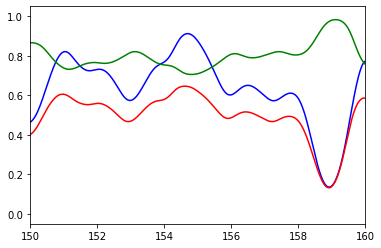

In [5]:
plt.plot(tAxis,x,'b')
plt.plot(tAxis,y,'r')
plt.plot(tAxis,gain,'g')
plt.xlim(150,160 )
# plt.xlim(100,110)

In [6]:
# xAutoConvolve = np.convolve( x-np.mean(x), x-np.mean(x), 'same' )
xAutoCorrelate = np.correlate( x-np.mean(x), x-np.mean(x), 'same' )
xyCorrelate = np.correlate( x-np.mean(x), y-np.mean(y), 'same' )

(148000.0, 152000.0)

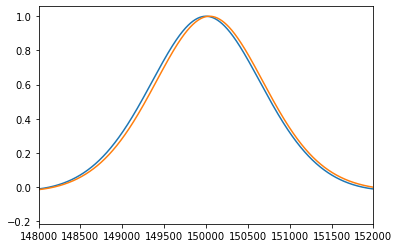

In [7]:
# plt.plot(xAutoConvolve)
plt.plot( xAutoCorrelate/max(xAutoCorrelate) )
plt.plot( xyCorrelate/max(xyCorrelate) )
plt.xlim(148000, 152000)

In [8]:
from scipy.fftpack import fft, fftfreq
def FFT_quick(data, dt, center_data = False, center_faxis = True):
    if center_data:
        xft=fft(data-np.mean(data))
    else:
        xft=fft(data)
    xft_nor=xft/len(xft)
    freq=fftfreq(len(data), d=dt)

    if center_faxis:
        xft_nor = np.append( xft_nor[np.argmin(freq):],xft_nor[:np.argmin(freq)] )
        freq = np.append( freq[np.argmin(freq):], freq[:np.argmin(freq)] )
    return freq,xft_nor

In [9]:
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

(0.0, 1.0)

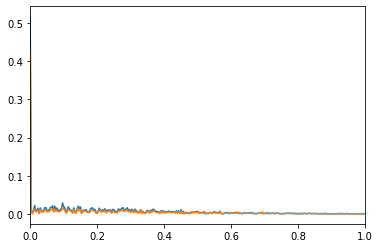

In [10]:
fAxis,FT_x=FFT_quick(x, dt)
fAxis,FT_y=FFT_quick(y, dt)
fAxis,FT_yy=FFT_quick(y**2, dt)
plt.plot(fAxis, np.abs(FT_x))
plt.plot(fAxis, np.abs(FT_y))
# plt.plot(fAxis, np.abs(FT_yy))
# plt.ylim(0,0.03)
plt.xlim(0, 1)

In [11]:
def ConvolveInFreqeuncyDomain(x, y):
    if len(x)!=len(y):     return -1
    xyCon = np.convolve(x, y, 'same')
    return np.append( xyCon[1:],xyCon[:1] )


(0.0, 1.0)

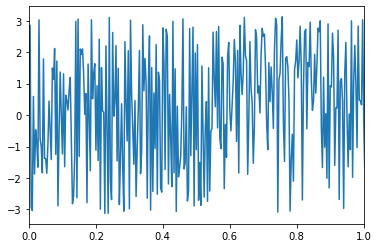

In [12]:
plt.plot(fAxis, np.angle(FT_x))
plt.xlim(0, 1)

In [13]:
H = FT_y/FT_x
G = np.abs(H)
Phi = np.angle(H)
delta = -angular_gradient(Phi)/np.mean(np.diff(fAxis))
PhaseDelay = -Phi/fAxis

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


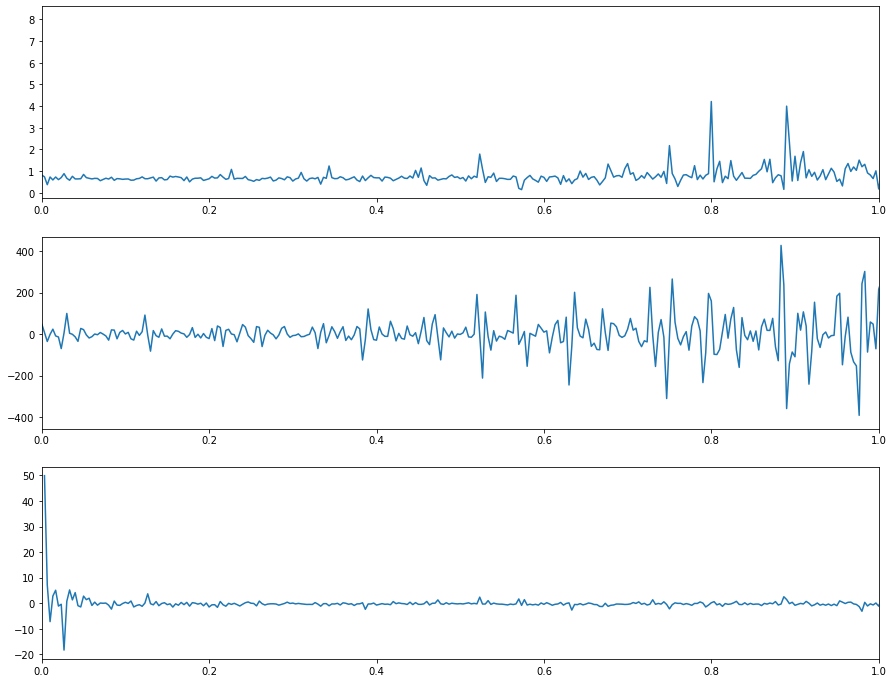

In [14]:
fig, ax = plt.subplots(3,1)
ax[0].plot(fAxis, G)
ax[1].plot(fAxis, delta)
ax[2].plot(fAxis, PhaseDelay)


# ax[1].set_ylim(-0.5,1.2)


for axi in ax:
    axi.set_xlim(0,1)

fig.set_size_inches(15,12)

(-0.05, 0.05)

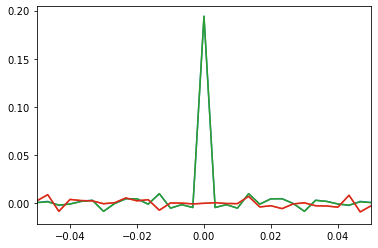

In [15]:
phaseshift = np.exp(1j*2*np.pi*fAxis*tau)
Gamma = FT_yy*phaseshift

plt.plot(fAxis, Gamma.real)
plt.plot(fAxis, Gamma.imag)

plt.plot(fAxis, FT_yy.real)
plt.plot(fAxis, FT_yy.imag)

# plt.plot(freq, np.abs(Gamma))
plt.xlim(-0.05,0.05)

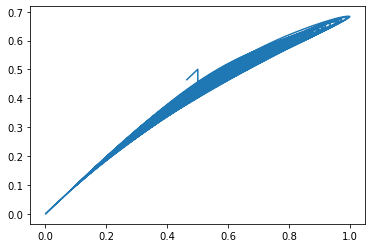

In [20]:
# plt.scatter(x,y)
plt.plot(x[delay:],y[delay:])

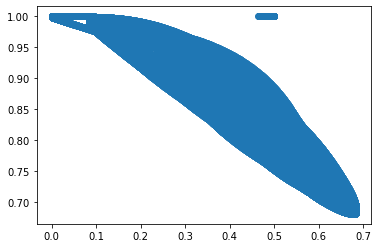

In [18]:
plt.scatter(y,gain)